In [1]:
from tensorflow.keras.datasets import mnist

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [3]:
### load mnist dataset and data preprocessing
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train shape:', x_train.shape)
print('        dtype:', x_train.dtype)

x_train shape: (60000, 28, 28)
        dtype: uint8


In [4]:
### outputs list of NxN patches from an image
def getPatches(image, patch_size, pad_size, stride):
    # find shape of original image and shape of output
    x_img, y_img = image.shape
    x_out = ((x_img - patch_size + 2 * pad_size) // stride) + 1
    y_out = ((y_img - patch_size + 2 * pad_size) // stride) + 1

    # pad original image
    image = np.pad(image, pad_width=pad_size, mode='constant', constant_values=0)

    # find all patches and place into output matrix
    output = np.empty((x_out, y_out, patch_size, patch_size), dtype='uint8')
    
    for x in range(x_out):
        for y in range(y_out):
            x_start = x * stride
            y_start = y * stride
            
            output[x,y] = image[x_start:(x_start + patch_size), y_start:(y_start + patch_size)]

    # reshape output to list
    output = output.reshape(-1, patch_size, patch_size)
    
    return output
    

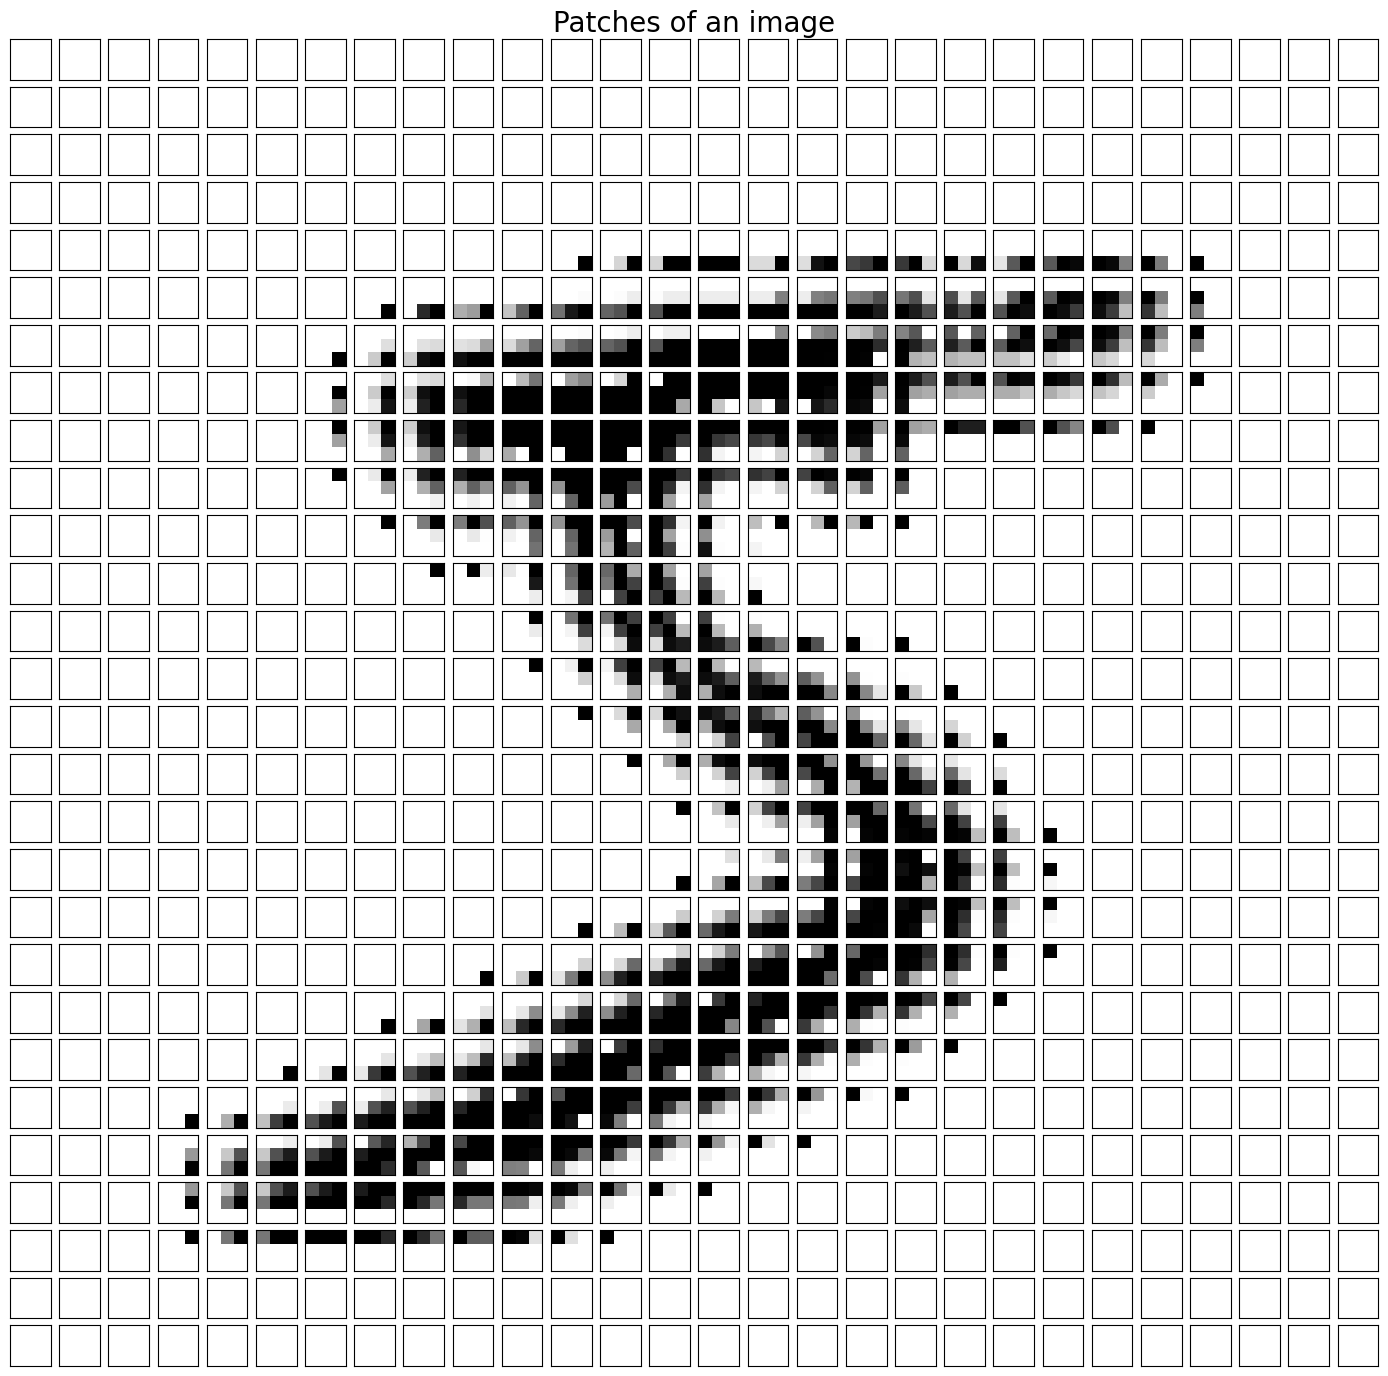

In [5]:
### visualize patches
patch_size = 3
pad_size = 1
stride = 1

image_patches = getPatches(x_train[0], patch_size, pad_size, stride)

num_row = 28
num_col = 28

fig, axes = plt.subplots(num_row, num_col, figsize=(0.5 * num_col, 0.5 * num_row))
for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(image_patches[i], cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Patches of an image", fontsize=20)
plt.tight_layout(w_pad=0.5, h_pad=0.5)
plt.show()

In [6]:
### extract all patches from a sample of images and store as points
patch_size = 3
pad_size = 1
stride = 1
sample_size = 100000

image_samples = x_train[:sample_size]

# TODO: doesn't work for non NxN images
patches_per_image = image_samples.shape[1] * image_samples.shape[2] 
image_points = np.empty((sample_size * patches_per_image, patch_size * patch_size), dtype='uint8')

for i, image in enumerate(image_samples):
    image_patches = getPatches(image, patch_size, pad_size, stride)
    image_patches = image_patches.reshape(image_patches.shape[0], -1)

    start = i * patches_per_image
    end = (i + 1) * patches_per_image
    image_points[start:end] = image_patches

In [7]:
### data preprocessing for k-means

print('image points original:', image_points.shape, image_points.dtype)

# extract nonzero points
image_points = image_points[~np.all(image_points == 0, axis=1)]
print('image points nonzero:', image_points.shape, image_points.dtype)

# change from uint8 to np.float32
image_points = image_points.astype(np.float32)

# normalize values 
image_points_min = np.min(image_points)
image_points_max = np.max(image_points)

if image_points_max - image_points_min != 0:
    image_points = (image_points - image_points_min) / (image_points_max - image_points_min)
else:
    image_points = np.zeros_like(image_points)

print('image points normalized:', image_points.shape, image_points.dtype)

image points original: (78400000, 9) uint8
image points nonzero: (14998456, 9) uint8
image points normalized: (14998456, 9) float32


In [8]:
### plot k-means functions

def plot_kmeans_initialization(points, centroids):
    plt.figure(figsize=(6,6))
    plt.scatter(
        points[:, 0], points[:, 1],
        marker='.', color='gray', label='Data Points'
    )
    plt.scatter(
        centroids[:, 0], centroids[:, 1],
        color='red', s=50, label='Centroids'
    )
    plt.title('K-means++ Initialization')
    plt.legend()
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.2)
    plt.show()

def plot_kmeans_iteration(points, centroids, labels, it):
    n_clusters = centroids.shape[0]
    cmap = plt.get_cmap('plasma')
    colors = cmap(np.linspace(0, 1, n_clusters))
    
    plt.figure(figsize=(6,6))
    for k in range(n_clusters):
        mask = labels == k
        plt.scatter(points[mask, 0], points[mask, 1], s=12, alpha=0.25, color=colors[k])
        
    plt.scatter(centroids[:, 0], centroids[:, 1],
                s=50, color=[colors[k] for k in range(n_clusters)], edgecolor='black', linewidth=0.8)

    plt.title(f"Lloyd's Algorithm — Iteration {it}")
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.2)
    plt.show()
    

In [9]:
### k-means: returns k number of centroids given a list of points

def k_means(points, n_clusters, max_iter=300, tol=0.0001):
    n_points, n_features = points.shape

    centroids = np.empty((n_clusters, n_features), dtype=points.dtype)
    labels = np.empty((n_points), dtype=np.int_)

    # k-means++ algorithm
    #   1. find first cluster uniformly at random
    #   for each next cluster:
    #     2. calc distance from each point to nearest center
    #     3. chose next center at random (proportionally weighted to square of distances)
    
    # find first cluster uniformly at randome
    rng = np.random.default_rng()
    centroids[0] = rng.choice(points)
    
    # squared distance from each point to first centroid
    dist_squared = np.sum((points - centroids[0]) ** 2, axis=1).astype(np.float32)
    
    for k in range(1, n_clusters):
        # select random point to be next centroid
        # weighted proportionally to square distance
        probs = dist_squared / np.sum(dist_squared)
        idx = np.random.choice(n_points, p=probs)
        centroids[k] = points[idx] 

        # find min squared distance from each point to previous centroids
        new_dist_squared = np.sum((points - centroids[k]) ** 2, axis=1).astype(np.float32)
        dist_squared = np.minimum(dist_squared, new_dist_squared)

    # plot k-means++ initialization
    if (n_features == 2):
        plot_kmeans_initialization(points, centroids)
    
    # lloyds algorithm
    #   1. compute point to centroid dist for all points to each centroid
    #   2. assign each point to cluster of closest centroid
    #   3. compute average of points in each cluster to gain k new centroids
    #   4. repeat steps 1 to 3 until assignementds don't change or max iterations is reached

    for it in range(max_iter):
        # find squared distance between each point and centroid
        #   reshape -> diff -> square -> sum -> argmin
        dist_squared = np.sum((points[:, None, :] - centroids[None, :, :]) ** 2, axis=2).astype(np.float32)
        
        # assign each point to cluster of centroid with smallest distance
        labels = np.argmin(dist_squared, axis=1)

        if (n_features == 2):
            plot_kmeans_iteration(points, centroids, labels, it + 1)
        
        # compute new centroids as mean of all points within a cluster 
        old_centroids = centroids.copy()
        for k in range(n_clusters):
            centroids[k] = np.mean(points[labels == k], axis=0)
        
        # calculate shifts of old to new centroids
        centroid_shifts = np.linalg.norm(centroids - old_centroids, axis=1)

        # break if little to no movement is made between centroid positions
        if np.max(centroid_shifts) < tol:
            print(f'K-means solved in {it + 1} iterations')
            break

        if (it == max_iter - 1):
            print(f'K-means solved in {max_iter} iterations')
            
    return centroids, labels

In [10]:
### define 2d convolution algorithm using matrix multiplication for multiple kernels
def conv2d_matrix(image, kernels, padding=0, stride=1):
    # change to float32
    image = image.astype(np.float32)
    kernels = kernels.astype(np.float32)
    
    # find shape of image and kernel
    x_img, y_img = image.shape
    n_kern, x_kern, y_kern = kernels.shape

    # find shape of output
    x_out = ((x_img - x_kern + 2 * padding) // stride) + 1
    y_out = ((y_img - y_kern + 2 * padding) // stride) + 1
    output = np.zeros((x_out, y_out), dtype=np.float32)

    # pad original image
    image_pad = np.pad(image, pad_width=padding, mode='constant', constant_values=0)
    
    # create im2col matrix
    im2col_matrix = np.zeros((x_kern * y_kern, x_out * y_out), dtype=np.float32)

    # iterate through image
    col_index = 0
    for x in range(x_out):
        for y in range (y_out): 
            x_start = x * stride
            y_start = y * stride
            
            # extract patch
            patch = image_pad[x_start:x_start + x_kern, y_start:y_start + y_kern] # find area windowed by kernel 

            # flatten patch into im2col matrix
            im2col_matrix[:, col_index] = patch.flatten()
            col_index += 1

    # flatten kernel
    kernel_flat = [k.flatten() for k in kernels]

    # matrix multiplication
    output = kernel_flat @ im2col_matrix

    # print("kernels shape", kernels.shape)
    # print("im2col shape", im2col_matrix.shape, im2col_matrix)
    # print("output shape", output.shape, output)

    return output

In [11]:
### apply k-means on all patches of images
n_clusters = 5
max_iter = 300
tol = 0.0001
centroids, labels = k_means(image_points, n_clusters, max_iter, tol)

K-means solved in 28 iterations


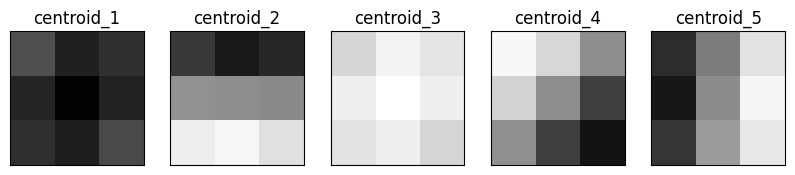

In [12]:
### visualize k-means result
centroid_patches = centroids.reshape(n_clusters, 3, 3)

centroid_patches_min = np.min(centroid_patches)
centroid_patches_max = np.max(centroid_patches)

num_row = 1
num_col = n_clusters
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col, 2*num_row))
for i in range(n_clusters):
    ax = axes[i]
    ax.imshow(centroid_patches[i], cmap='gray_r', vmin=0, vmax=1)
    ax.set_title(f"centroid_{i+1}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# normalize patches [-1, 1]
if centroid_patches_max - centroid_patches_min != 0:
    centroid_patches = 2 * ((centroid_patches - centroid_patches_min) / (centroid_patches_max - centroid_patches_min)) - 1
else:
    image_points = np.zeros_like(image_points)


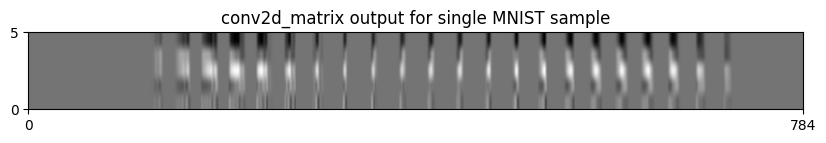

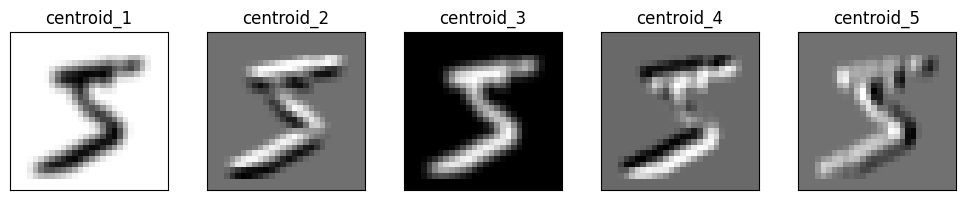

In [13]:
### apply k-means result as kernel on samples
image_sample = x_train[0]
out_matrix = conv2d_matrix(image_sample, centroid_patches, pad_size, stride)

fig = plt.figure(figsize=(10, 1))
plt.imshow(out_matrix, cmap='gray_r', aspect='auto', extent=[0, out_matrix.shape[1], 0, out_matrix.shape[0]])
plt.title("conv2d_matrix output for single MNIST sample")
plt.xticks([0, out_matrix.shape[1]])
plt.yticks([0, out_matrix.shape[0]])
plt.show()

feature_maps = list(out_matrix)
reshape_size = int(math.sqrt(len(feature_maps[0])))
for i in range(len(feature_maps)):
    feature_maps[i] = feature_maps[i].reshape(reshape_size, reshape_size)

kernel_labels = [f'centroid_{k+1}' for k in range(n_clusters)]
num_row = 1
num_col = n_clusters

fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col, 2*num_row))
for i in range(len(feature_maps)):
    ax = axes[i]
    ax.imshow(feature_maps[i], cmap='gray_r')
    ax.set_title(kernel_labels[i])
    ax.set_xticks([])
    ax.set_yticks([])

# fig.suptitle("conv2d_matrix on mnisk sample") 
plt.tight_layout()
plt.show()

In [14]:
### generate 2d points for testing
mean_01 = np.array([0.0, 0.0])
cov_01 = np.array([[1, 0.3], [0.3, 1]])
dist_01 = np.random.multivariate_normal(mean_01, cov_01, 100)

mean_02 = np.array([6.0, 7.0])
cov_02 = np.array([[1.5, 0.3], [0.3, 1]])
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 100)

mean_03 = np.array([7.0, -5.0])
dist_03 = np.random.multivariate_normal(mean_03, cov_01, 100)

mean_04 = np.array([2.0, -7.0])
cov_04 = np.array([[1.2, 0.5], [0.5, 1.3]])
dist_04 = np.random.multivariate_normal(mean_04, cov_01, 100)

data = np.vstack((dist_01, dist_02, dist_03, dist_04))
np.random.shuffle(data)

# normalize points
data_min = np.min(data, axis=0)
data_max = np.max(data, axis=0)

range_ = data_max - data_min
range_[range_ == 0] = 1

data = (data - data_min) / range_# generate points for testing
mean_01 = np.array([0.0, 0.0])
cov_01 = np.array([[1, 0.3], [0.3, 1]])
dist_01 = np.random.multivariate_normal(mean_01, cov_01, 100)

mean_02 = np.array([6.0, 7.0])
cov_02 = np.array([[1.5, 0.3], [0.3, 1]])
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 100)

mean_03 = np.array([7.0, -5.0])
dist_03 = np.random.multivariate_normal(mean_03, cov_01, 100)

mean_04 = np.array([2.0, -7.0])
cov_04 = np.array([[1.2, 0.5], [0.5, 1.3]])
dist_04 = np.random.multivariate_normal(mean_04, cov_01, 100)

data = np.vstack((dist_01, dist_02, dist_03, dist_04))
np.random.shuffle(data)

# normalize points
data_min = np.min(data, axis=0)
data_max = np.max(data, axis=0)

range_ = data_max - data_min
range_[range_ == 0] = 1

data = (data - data_min) / range_

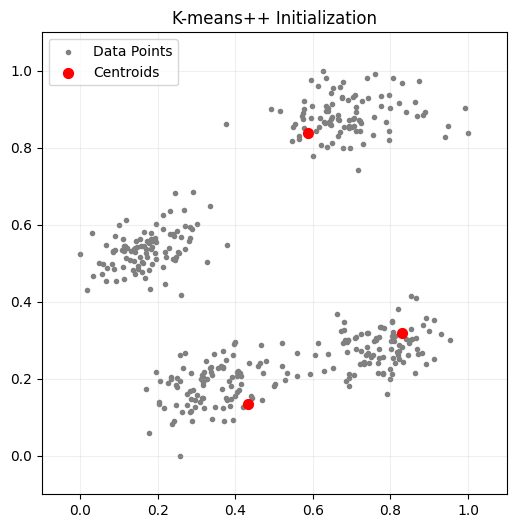

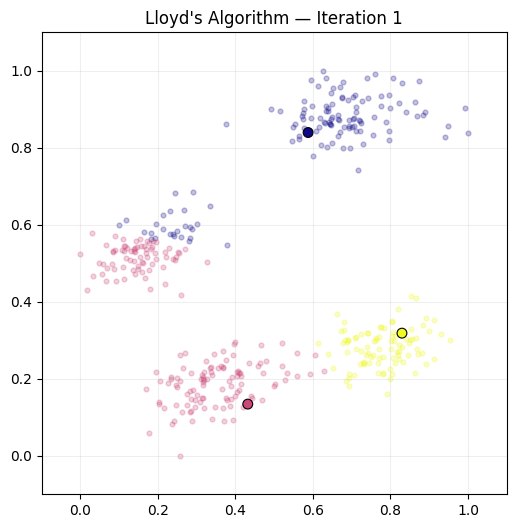

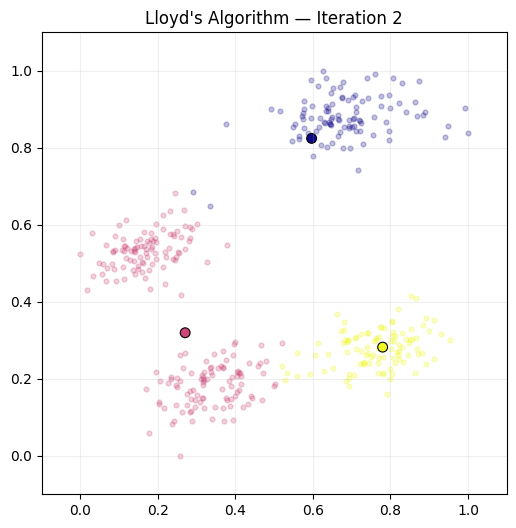

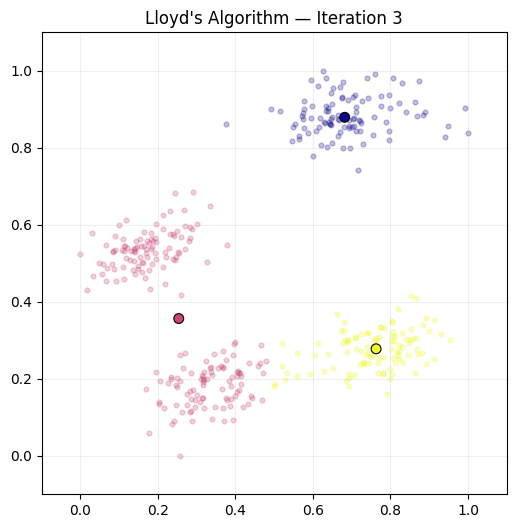

K-means solved in 3 iterations


In [16]:
### k-means testing on 2d point space

# find centroids
centroids, labels = k_means(data, 3, 20, 0.01)